In [1]:
import pandas as pd
import os
import numpy as np
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import clear_output
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA

In [3]:
def create_frame(state):
    weather = pd.read_csv(f'collated_data/{state}.csv')
    energy = pd.read_csv(f'power_consumption/{state}.csv')
    energy.set_index('Year', inplace=True)
    weather['Year'] = weather.Date.astype(str).str[:4].astype(int)
    weatherly = weather.groupby('Year').mean().drop(columns=['Date'])
    weathergy = pd.concat([weatherly[['tavg','cdd','hdd','tmax','tmin']], energy], axis=1)
    return weathergy

In [7]:
def create_subplots(y_col1, y_col2, dataframe, width=1000, height=800):
    fig = make_subplots(
        rows=2, cols=2,
        row_heights=[0.7, 0.3],
        shared_xaxes=True,
        vertical_spacing=0.1,
        column_widths=[1, 1],
        specs=[[{"colspan": 2}, None], [{"type": "scatter"}, {"type": "scatter"}]]
    )

    fig.add_trace(
        go.Scatter(x=dataframe[y_col1], y=dataframe[y_col2], mode='markers', name=f'{y_col1} vs {y_col2}',
                  customdata=dataframe.index,
                  hovertemplate="<br>".join([
                      y_col1 + ": %{x}", 
                      y_col2 + ": %{y}",
                      'Year: %{customdata}',
                  ])
                  ), 
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(x=dataframe.index, y=dataframe[y_col1], mode='lines', name=f'{y_col1} over year'),
        row=2, col=1
    )

    fig.add_trace(
        go.Scatter(x=dataframe.index, y=dataframe[y_col2], mode='lines', name=f'{y_col2} over year'),
        row=2, col=2
    )

    fig.update_layout(
        width=width,
        height=height,
        showlegend=True,
        template="plotly_white",
        legend=dict(x=0.5, y=1, traceorder='normal', orientation='h', xanchor='center', yanchor='bottom'),
        title=None
    )

    fig.update_yaxes(title_text=f'{y_col2}', row=1, col=1)
    # fig.update_xaxes(title_text='Year', row=1, col=1)

    fig.update_xaxes(title_text=None, row=2, col=1)
    fig.update_yaxes(title_text=None, row=2, col=1)
    fig.update_xaxes(title_text=None, row=2, col=2)
    fig.update_yaxes(title_text=None, row=2, col=2)

    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)

    fig.update_layout(
        xaxis=dict(showline=True, linewidth=2, linecolor='black'),
        yaxis=dict(showline=True, linewidth=2, linecolor='black'),
        xaxis2=dict(showline=True, linewidth=2, linecolor='black'),
        yaxis2=dict(showline=True, linewidth=2, linecolor='black'),
        xaxis3=dict(showline=True, linewidth=2, linecolor='black'),
        yaxis3=dict(showline=True, linewidth=2, linecolor='black')
    )
    x_start = dataframe.index.min() - 3
    x_end = dataframe.index.max() + 1 

    fig.update_xaxes(range=[x_start, x_end], row=2, col=1)
    fig.update_xaxes(range=[x_start, x_end], row=2, col=2)

    fig.show()

# Power Relationships Analysis

This notebook explores the relationships between weather and consumption metrics for various states. We will check the relationship between the weather stats (`tavg`, `hdd`, `cdd`) and consumption stats (Residential, Commercial, Industrial, Transportation, and Total consumption) for each state. The relationships will be validated interactively, and the results will be saved to CSV files.

## Code to Analyze Relationships

The following code runs through all states in the dataset, checks relationships between weather and consumption, and stores the validated results in CSV files.

```python
import os
import pandas as pd
from IPython.display import clear_output

weather_stats = ['tavg', 'hdd', 'cdd']
consumption_stats = ['Residential sector', 'Commercial sector', 'Industrial sector', 'Transportation sector', 'Total consumption']

os.makedirs('power_relationships', exist_ok=True)


for state in os.listdir('collated_data'):
    relationships = []
    if state in os.listdir('power_relationships'):
        continue
    state = state.replace('.csv', '')
    weathergy = create_frame(state)
    
    for weather in weather_stats:
        for consumption in consumption_stats:
            clear_output()
            create_subplots(weather, consumption, dataframe=weathergy)

            check = input(f'Check if relationship between {weather} and {consumption} is valid for {state}? Y/N')
            if check.lower() == 'y':
                relationships.append([weather, consumption])
            else:
                continue

    relationships_df = pd.DataFrame(relationships, columns=['Weather', 'Consumption'])
    relationships_df.to_csv(f'power_relationships/{state}.csv', index=False)


In [12]:
## Do not run this again. 
# weather_stats = ['tavg', 'hdd', 'cdd']
# consumption_stats = ['Residential sector', 'Commercial sector', 'Industrial sector', 'Transportation sector', 'Total consumption']


# os.makedirs('power_relationships', exist_ok = True)
# for state in os.listdir('collated_data'):
#     relationships = []
#     if state in os.listdir('power_relationships'):
#         continue
#     state = state.replace('.csv','')
#     weathergy = create_frame(state)
#     for weather in weather_stats:
#         for consumption in consumption_stats:
#             clear_output()
#             create_subplots(weather, consumption, dataframe=weathergy)

#             check = input(f'Check if relationship between {weather} and {consumption} is valid for {state}? Y/N')

#             if check.lower() in ['y']:
#                 relationships.append([weather, consumption])
#             else:
#                 continue
#     relationships_df = pd.DataFrame(relationships, columns = ['Weather', 'Consumption'])
#     relationships_df.to_csv(f'power_relationships/{state}.csv', index=False)

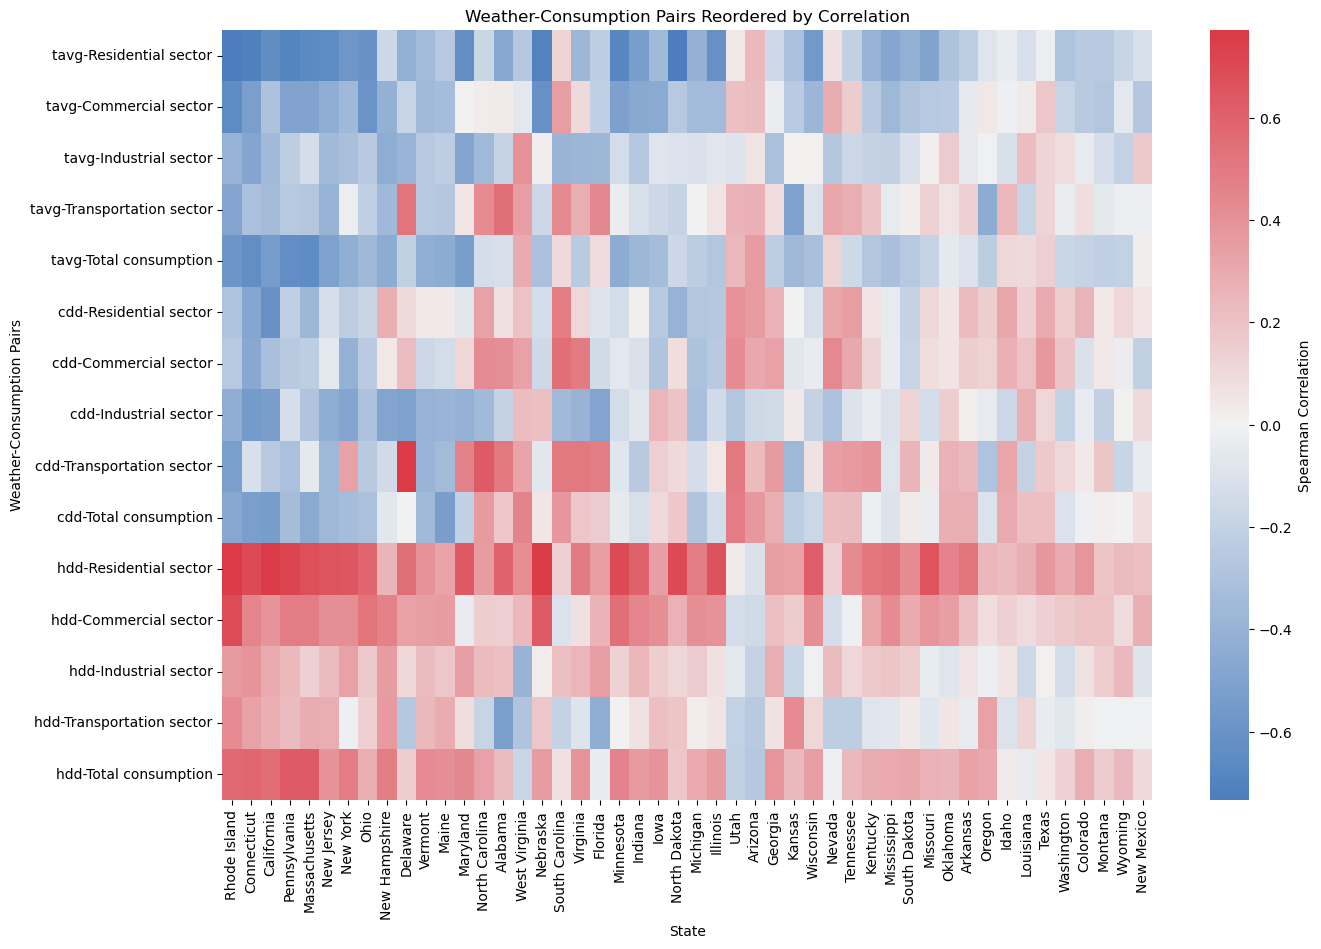

In [14]:
weather_stats = ['tavg', 'cdd', 'hdd']
consumption_stats = ['Residential sector', 'Commercial sector', 'Industrial sector', 'Transportation sector', 'Total consumption']

def compute_spearmanr(weather_stats, consumption_stats):
    results = []
    for state in os.listdir('collated_data'):
        state = state.replace('.csv','')
        weathergy = create_frame(state)
        row = {'state': state}
        for weather in weather_stats:
            for consumption in consumption_stats:
                corr, _ = spearmanr(weathergy[weather], weathergy[consumption])
                row[f'{weather}-{consumption}'] = corr

        results.append(row)
    return pd.DataFrame(results)

def visualize_corr(corr_df):
    melt_df = corr_df.melt(id_vars='state', var_name='Pair', value_name='Correlation')

    corr_matrix = corr_df.set_index('state').transpose()
    pair_correlation_strength = corr_matrix.abs().mean(axis=0) 
    sorted_pairs = pair_correlation_strength.sort_values(ascending=False).index

    reordered_corr = corr_matrix[sorted_pairs]

    plt.figure(figsize=(15, 10))
    sns.heatmap(
        reordered_corr,
        cmap=sns.diverging_palette(250, 10, as_cmap=True),
        center=0,
        annot=False,
        cbar_kws={'label': 'Spearman Correlation'},
    )
    plt.title('Weather-Consumption Pairs Reordered by Correlation')
    plt.ylabel('Weather-Consumption Pairs')
    plt.xlabel('State')
    plt.show()

corr_df = compute_spearmanr(weather_stats, consumption_stats)

visualize_corr(corr_df)

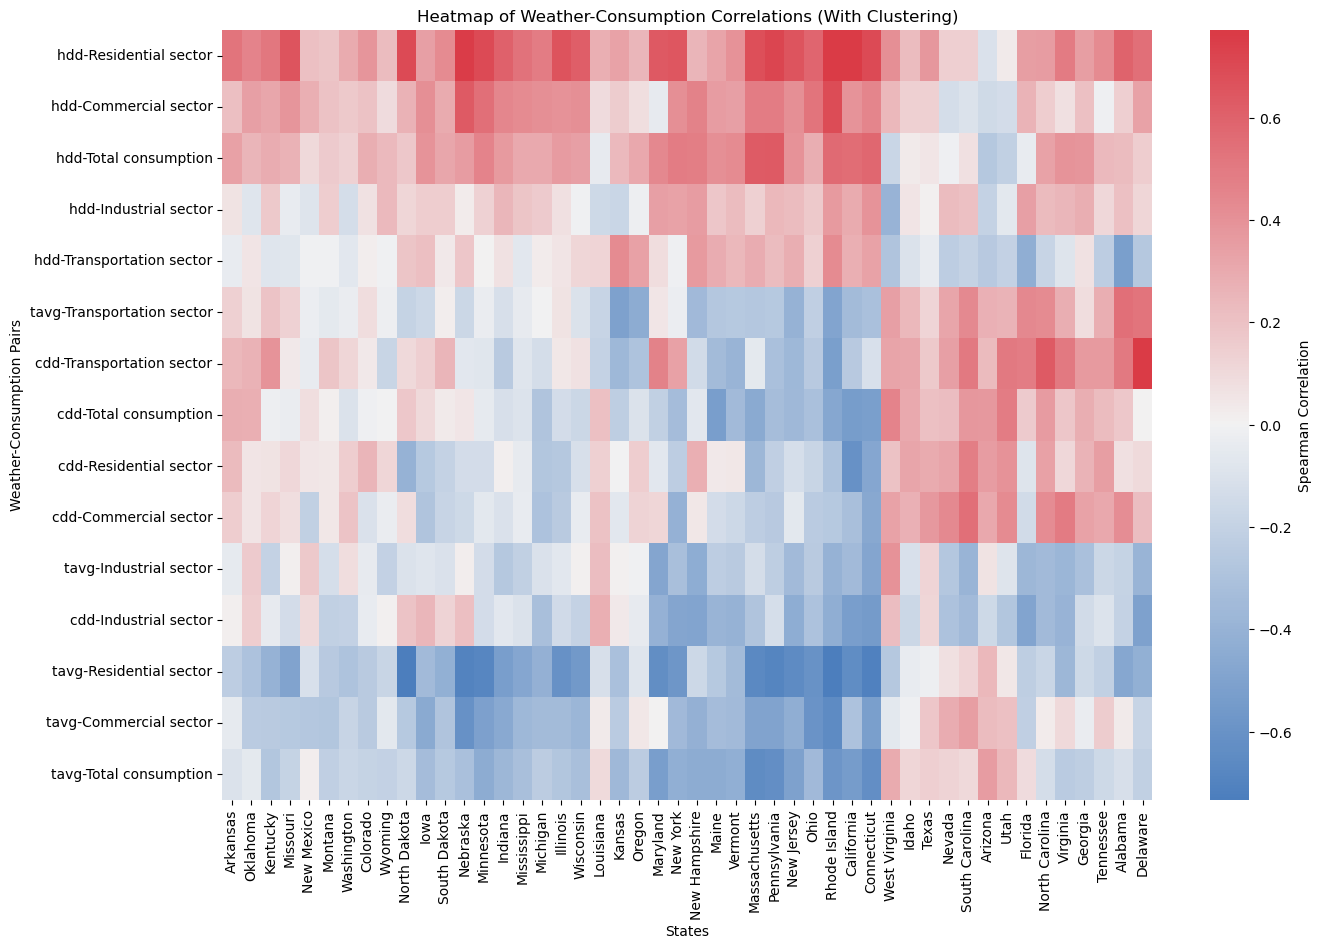

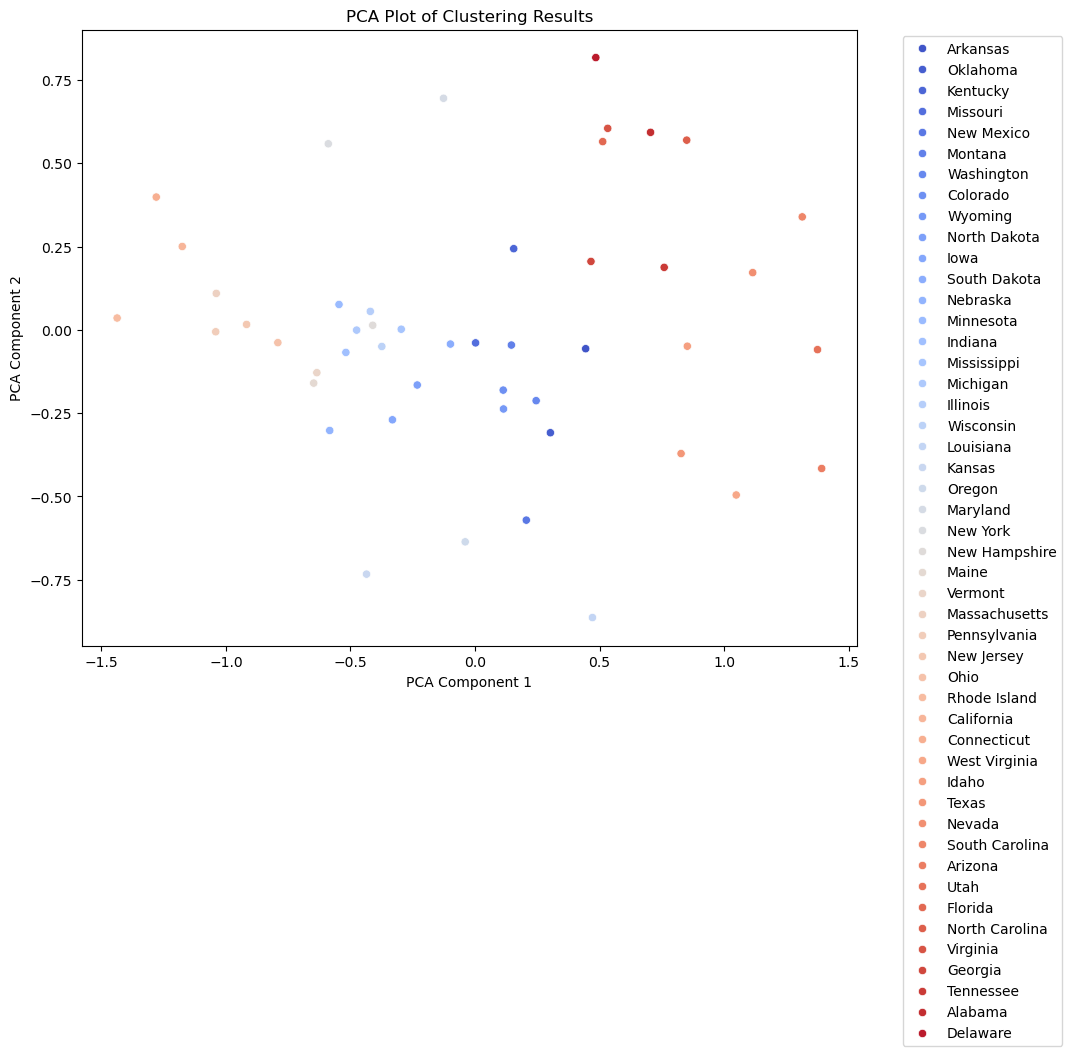

In [16]:
## PCA Clustering

def plot_clustering_on_scatter(corr_df):
    corr_matrix = corr_df.set_index('state').transpose() 

    corr_matrix_values = corr_matrix.values 
    row_linkage = sch.linkage(corr_matrix_values, method='average', metric='euclidean')
    col_linkage = sch.linkage(corr_matrix_values.T, method='average', metric='euclidean') 

    row_dendro = sch.dendrogram(row_linkage, no_plot=True)
    col_dendro = sch.dendrogram(col_linkage, no_plot=True)

    row_order = row_dendro['leaves']
    col_order = col_dendro['leaves']

    reordered_corr = corr_matrix.iloc[row_order, col_order]

    plt.figure(figsize=(15, 10))
    sns.heatmap(
        reordered_corr,
        cmap=sns.diverging_palette(250, 10, as_cmap=True), 
        center=0,
        annot=False,
        cbar_kws={'label': 'Spearman Correlation'},
    )
    plt.title('Heatmap of Weather-Consumption Correlations (With Clustering)')
    plt.ylabel('Weather-Consumption Pairs')
    plt.xlabel('States')
    plt.show()

    pca = PCA(n_components=2) 
    pca_components = pca.fit_transform(reordered_corr.T) 
    pca_df = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2'], index=reordered_corr.columns)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PCA1', y='PCA2', data=pca_df, hue=pca_df.index, palette='coolwarm')
    plt.title('PCA Plot of Clustering Results')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

plot_clustering_on_scatter(corr_df)

In [20]:
state_to_region = {
    'Alabama': 'South', 'Alaska': 'West', 'Arizona': 'West', 'Arkansas': 'South',
    'California': 'West', 'Colorado': 'West', 'Connecticut': 'Northeast', 'Delaware': 'South',
    'Florida': 'South', 'Georgia': 'South', 'Hawaii': 'West', 'Idaho': 'West',
    'Illinois': 'Midwest', 'Indiana': 'Midwest', 'Iowa': 'Midwest', 'Kansas': 'Midwest',
    'Kentucky': 'South', 'Louisiana': 'South', 'Maine': 'Northeast', 'Maryland': 'South',
    'Massachusetts': 'Northeast', 'Michigan': 'Midwest', 'Minnesota': 'Midwest', 'Mississippi': 'South',
    'Missouri': 'Midwest', 'Montana': 'West', 'Nebraska': 'Midwest', 'Nevada': 'West',
    'New Hampshire': 'Northeast', 'New Jersey': 'Northeast', 'New Mexico': 'West', 'New York': 'Northeast',
    'North Carolina': 'South', 'North Dakota': 'Midwest', 'Ohio': 'Midwest', 'Oklahoma': 'South',
    'Oregon': 'West', 'Pennsylvania': 'Northeast', 'Rhode Island': 'Northeast', 'South Carolina': 'South',
    'South Dakota': 'Midwest', 'Tennessee': 'South', 'Texas': 'South', 'Utah': 'West',
    'Vermont': 'Northeast', 'Virginia': 'South', 'Washington': 'West', 'West Virginia': 'South',
    'Wisconsin': 'Midwest', 'Wyoming': 'West'
}

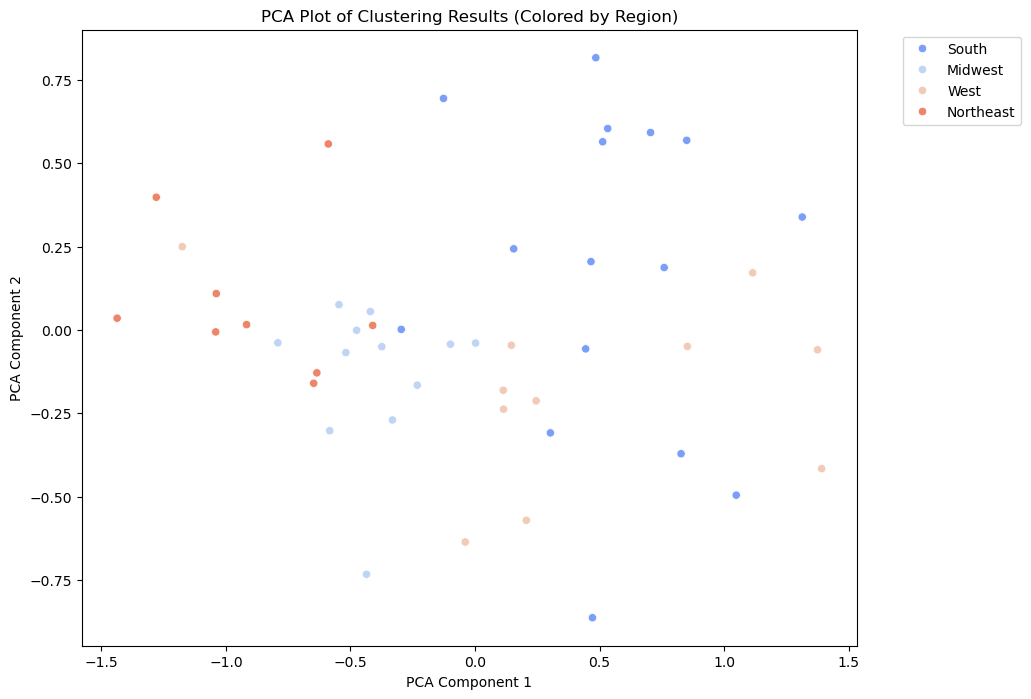

In [22]:
def plot_clustering_on_scatter(corr_df, state_to_region):
    corr_matrix = corr_df.set_index('state').transpose()  

    
    corr_matrix_values = corr_matrix.values 
    row_linkage = sch.linkage(corr_matrix_values, method='average', metric='euclidean')
    col_linkage = sch.linkage(corr_matrix_values.T, method='average', metric='euclidean')

    row_dendro = sch.dendrogram(row_linkage, no_plot=True) 
    col_dendro = sch.dendrogram(col_linkage, no_plot=True) 

    row_order = row_dendro['leaves'] 
    col_order = col_dendro['leaves'] 

    reordered_corr = corr_matrix.iloc[row_order, col_order]

    pca = PCA(n_components=2) 
    pca_components = pca.fit_transform(reordered_corr.T)  
    pca_df = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2'], index=reordered_corr.columns)

    pca_df['Region'] = pca_df.index.map(state_to_region)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PCA1', y='PCA2', data=pca_df, hue='Region', palette='coolwarm')
    plt.title('PCA Plot of Clustering Results (Colored by Region)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

plot_clustering_on_scatter(corr_df, state_to_region)

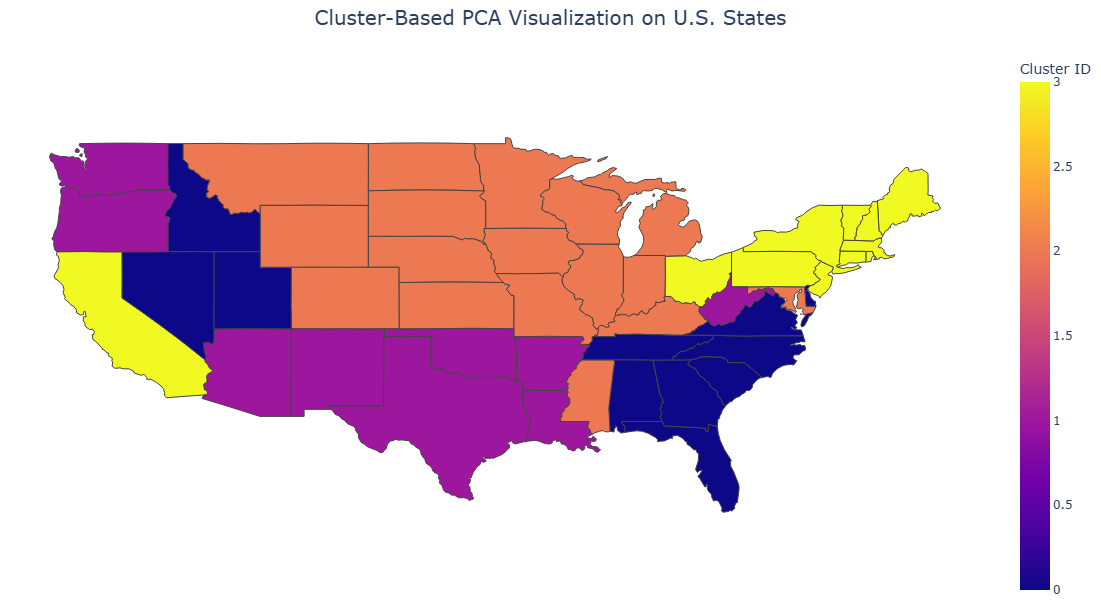

In [95]:
from sklearn.cluster import KMeans
import warnings
import geopandas as gpd

def plot_pca_choropleth_on_map(corr_df, geojson_path, n_clusters=4):

    corr_matrix = corr_df.set_index('state').transpose()  
    corr_matrix_values = corr_matrix.values
    pca = PCA(n_components=3)
    pca_components = pca.fit_transform(corr_matrix_values.T) 
    
    pca_df = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2','PCA3'], index=corr_matrix.columns)
    if n_clusters==4:
        random_state=48
    elif n_clusters==5:
        random_state=57
    else:
        random_state=42   
        
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
        pca_df['Cluster'] = kmeans.fit_predict(pca_df[['PCA1', 'PCA2','PCA3']]) 
    
    state_cluster_mapping = pca_df['Cluster'].to_dict()
    
    geo_df = gpd.read_file(geojson_path)
    
    
    geo_df['Cluster'] = geo_df['name'].map(state_cluster_mapping) 
    
    fig = px.choropleth(geo_df,
                        geojson=geo_df.geometry,
                        locations=geo_df.index,
                        color='Cluster',
                        hover_name='name',
                        color_discrete_sequence=px.colors.qualitative.Set1, 
                        labels={'Cluster': 'Cluster ID'},
                        title="Cluster-Based PCA Visualization on U.S. States")
    
   
    # fig.update_geos(fitbounds="locations", visible=False)
    fig.update_traces(showlegend=False)
    fig.update_layout(
        title="Cluster-Based PCA Visualization on U.S. States", 
        title_x=0.5,
        title_font_size=20,
        showlegend=False,  
        geo=dict(
            visible=False,
            fitbounds="locations"
        ),
        margin={"r": 0, "t": 50, "l": 0, "b": 0},  
        height=600,
        width=1000
    )
    fig.show()

plot_pca_choropleth_on_map(corr_df, 'us-states.json')

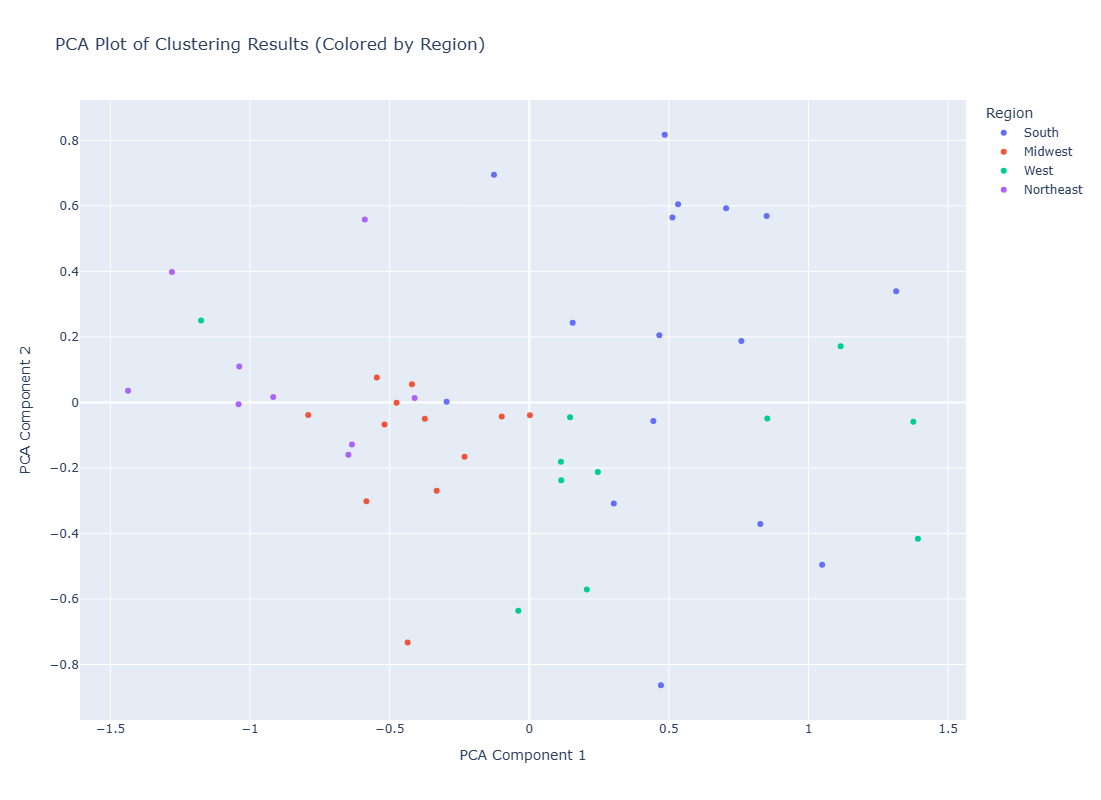

In [26]:
def plot_clustering_on_scatter(corr_df):
    corr_matrix = corr_df.set_index('state').transpose() 

    corr_matrix_values = corr_matrix.values 
    row_linkage = sch.linkage(corr_matrix_values, method='average', metric='euclidean')
    col_linkage = sch.linkage(corr_matrix_values.T, method='average', metric='euclidean')

    row_dendro = sch.dendrogram(row_linkage, no_plot=True)  
    col_dendro = sch.dendrogram(col_linkage, no_plot=True) 

    row_order = row_dendro['leaves'] 
    col_order = col_dendro['leaves'] 

    reordered_corr = corr_matrix.iloc[row_order, col_order]

    pca = PCA(n_components=2) 
    pca_components = pca.fit_transform(reordered_corr.T) 
    pca_df = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2'], index=reordered_corr.columns)


    pca_df['Region'] = pca_df.index.map(state_to_region)

    pca_df['State'] = pca_df.index

    fig = px.scatter(pca_df, x='PCA1', y='PCA2', color='Region', hover_data=['State', 'Region'],
                     title="PCA Plot of Clustering Results (Colored by Region)",
                     labels={'PCA1': 'PCA Component 1', 'PCA2': 'PCA Component 2'},
                     height=800)  

    for region in pca_df['Region'].unique():
        region_data = pca_df[pca_df['Region'] == region]
        
        cov_matrix = np.cov(region_data[['PCA1', 'PCA2']].T)
        mean = region_data[['PCA1', 'PCA2']].mean()
        
        eigvals, eigvecs = np.linalg.eigh(cov_matrix)

        angle = np.arctan2(*eigvecs[:, 0][::-1])
        angle = np.degrees(angle)

    fig.show()
    
plot_clustering_on_scatter(corr_df)